In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Input,UpSampling2D
from keras.utils import to_categorical
from keras import Model


Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### Agregar dimensión al tensor y normalizar

In [3]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

### Codificación one hot

In [4]:
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

### Instanciar red

In [5]:
convNN = Sequential()

### Añadir capas

In [6]:
convNN.add(Conv2D(filters     =32, 
                  kernel_size =(3, 3), 
                  activation  ='relu', 
                  input_shape =(28, 28, 1)))

convNN.add(MaxPooling2D(pool_size=(2, 2)))
convNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(MaxPooling2D(pool_size=(2, 2)))
convNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
convNN.add(Flatten())
convNN.add(Dense(units=64, activation='relu'))
convNN.add(Dense(units=10, activation='softmax'))

In [7]:
convNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [8]:
convNN.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
convNN.fit(train_images,train_labels,epochs=2)

Epoch 1/2
60000/60000 [==============================] - 42s 693us/step - loss: 0.1387 - accuracy: 0.9564
Epoch 2/2
60000/60000 [==============================] - 39s 657us/step - loss: 0.0424 - accuracy: 0.9873


In [10]:
test_loss, test_acc = convNN.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 184us/step


In [11]:
print('Accuracy:' ,test_acc)

Accuracy: 0.9884999990463257


### Transfer Learning

In [12]:
from keras.applications.vgg16 import VGG16
new_input = Input(shape=(640, 480, 3))
model = VGG16(include_top=False, input_tensor=new_input)

In [13]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 640, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 640, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 640, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 320, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 320, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 320, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 160, 120, 128)     0     

### Autoencoder

In [14]:
input_img = Input(shape=(28, 28, 1))  
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [15]:
x = Conv2D(8, (3, 3), activation='relu', padding='same',name = "entry_encoded")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [16]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [17]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0   

In [18]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [21]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples


AttributeError: 'Model' object has no attribute '_get_distribution_strategy'

In [22]:
encoder_layer = autoencoder.layers[0]
encoder = Model(input_img,encoded)

In [23]:
decoded_input = Input(shape=(4,4,8,))
deco = autoencoder.layers[-7](decoded_input)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
decoder = Model(decoded_input,deco)

In [24]:
encodes = encoder.predict(x_test)
encoded.shape

TensorShape([None, 4, 4, 8])

In [25]:
decodes = decoder.predict(encodes)

In [26]:
decodes.shape

(10000, 28, 28, 1)

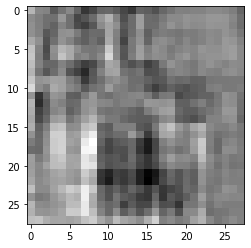

In [27]:
import cv2
plt.imshow(decodes[2,:,:,0],cmap= 'gray')

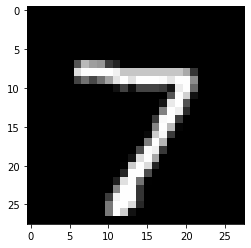

In [36]:
plt.imshow(x_test[0][:,:,0],cmap = 'gray')